In [1]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated
using FluxExtensions
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate

push!(LOAD_PATH, "../", "/home/jan/dev/anomaly detection/anomaly_detection/src")
using KNNmem
using AnomalyDetection

include("../train_and_track.jl");

In [2]:
# Prepare data

dataPath = "/home/jan/dev/data/loda/public/datasets/numerical"
allData = AnomalyDetection.loaddata(dataPath)

dataset = allData["musk-2"]
train, test, clusterdness = AnomalyDetection.makeset(dataset, 0.9, "normal", 0.1, "high")
inputSize = size(train.data, 1)

166

In [3]:
# Model with memory

memoryModel = Chain(
  FluxExtensions.ResDense(inputSize, 32, relu),
  FluxExtensions.ResDense(32, 2, relu))

memory = KNNmemory(2000, 2, 64, 10)

# Model without memory

classicModel = Chain(
  FluxExtensions.ResDense(inputSize, 32, relu),
  FluxExtensions.ResDense(32, 2, relu),
  softmax)

Chain(ResDense(Dense(32, 32, NNlib.relu)), ResDense(Dense(2, 2, NNlib.relu)), NNlib.softmax)

In [4]:
# Training setup

memLoss(x, y) = trainQuery!(memory, memoryModel(x), y)
memPerformance(x, y) = mean(query(memory, memoryModel(x)) .== y)
memOpt = ADAM(params(memoryModel))

classicLoss(x, y) = Flux.mse(classicModel(x), y)
classicOpt = ADAM(params(classicModel))
classicPerformance(x, y) = mean(argmax(classicModel(x)) .== argmax(y))

iterations = 100
batchSize = 1000
printInterationCount = 10

10

In [5]:
memHistory = trainAndTrack!(memLoss, memPerformance, memOpt, iterations, batchSize, train.data, train.labels, test.data, test.labels, printInterationCount)
classicHistory = trainAndTrack!(classicLoss, classicPerformance, classicOpt, iterations, batchSize, train.data, Flux.onehotbatch(train.labels, 0:1), test.data, Flux.onehotbatch(test.labels, 0:1), printInterationCount)

0.0691476871884032
0.04768899654258138
0.04418474744856344
0.045536740732958284
0.04488912512960462
0.04491356531522338
0.046073732618631895
0.046580567022140154
0.04489245208746215
0.04534546434773861
0.14709532234309494
0.07267033147339372
0.06319827463206919
0.06127644383325307
0.04935620105868729
0.05188050217491833
0.05495911398302842
0.05778997273403832
0.05053902773328254
0.05105856779767789


MVHistory{ValueHistories.History}
  :performance => 10 elements {Int64,Float64}
  :trainLoss => 10 elements {Int64,Float64}

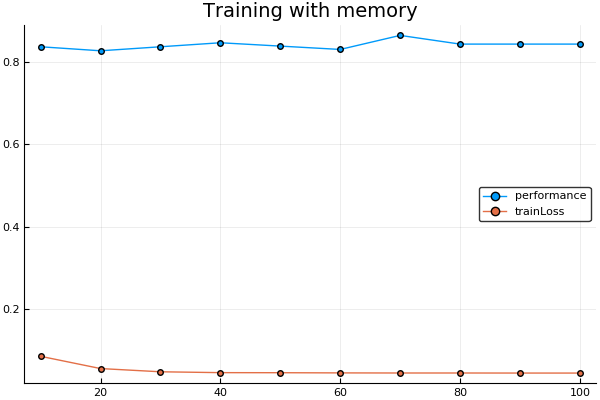

In [6]:
# Plot training

using Plots
pyplot()

plot(memHistory)
plot!(title = "Training with memory")

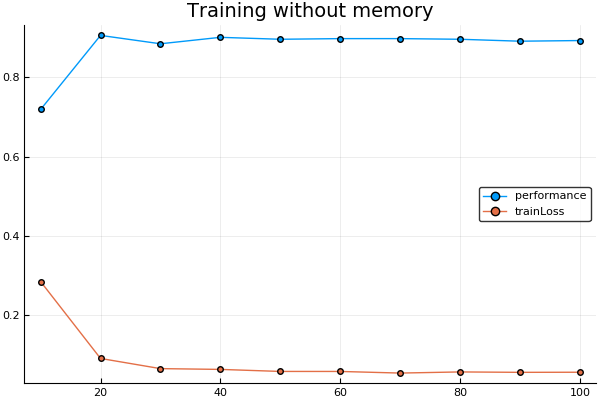

In [7]:
plot(classicHistory)
plot!(title = "Training without memory")

In [8]:
# ROC with memory

rocData = roc(test.labels, query(memory, memoryModel(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

MLBase.ROCNums{Int64}
  p = 56
  n = 559
  tp = 21
  tn = 504
  fp = 55
  fn = 35
precision: 0.27631578947368424
f1score: 0.3181818181818182
recall: 0.375
false positive rate: 0.09838998211091235
equal error rate: 0.36169499105545616


In [9]:
# ROC without memory

rocData = roc(test.labels, argmax(classicModel(test.data)))
print(rocData)
print("precision: $(precision(rocData))\n")
print("f1score: $(f1score(rocData))\n")
print("recall: $(recall(rocData))\n")
print("false positive rate: $(false_positive_rate(rocData))\n")
print("equal error rate: $((false_positive_rate(rocData) + false_negative_rate(rocData))/2)\n")

MLBase.ROCNums{Int64}
  p = 56
  n = 559
  tp = 39
  tn = 0
  fp = 559
  fn = 0
precision: 0.06521739130434782
f1score: 0.12244897959183673
recall: 0.6964285714285714
false positive rate: 1.0
equal error rate: 0.5
